In [2]:
!pip install opencv-python==4.6.0.66 matplotlib==3.6.2 imageio==2.23.0 gdown==4.6.0 tensorflow==2.10.1 --upgrade tensorboard keras

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)


In [3]:
!pip list

Package                       Version
----------------------------- -------------------
absl-py                       1.4.0
aiohttp                       3.8.4
aiosignal                     1.3.1
alabaster                     0.7.12
ale-py                        0.7.4
altair                        5.0.1
anaconda-client               1.11.2
anaconda-navigator            2.4.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
AutoROM                       0.6.1
AutoROM.accept-rom-license    0.6.1
Babel 

In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [7]:
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# Build Data Loading Functions

In [8]:
import gdown

In [9]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: C:\Users\yacoo\LipReadingDeepLearning\LipReading\data.zip
100%|███████████████████████████████████████████████████████████████████████████████| 423M/423M [00:38<00:00, 10.9MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [10]:
def load_video(path: str) -> List[float]:
    
    cap = cv2.VideoCapture(path)
    frames = []
    
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        # Isolating the mouth region using positions
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    
    return tf.cast((frames - mean), tf.float32) / std

In [11]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [18]:
# oov_token: blank value for character it has not seen before
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size = 40)


In [19]:
char_to_num(['b','e','n'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([ 2,  5, 14], dtype=int64)>

In [20]:
num_to_char([ 2,  5, 14])

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'b', b'e', b'n'], dtype=object)>

In [21]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
        
    tokens = []
    
    for line in lines:
        line = line.split()
        
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
            
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [22]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [23]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [30]:
tf.convert_to_tensor(test_path).numpy().decode('UTF-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [32]:
# Convert raw string to tensor
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [40]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.4603739 ],
         [ 1.4603739 ],
         [ 1.4209043 ],
         ...,
         [ 0.15787826],
         [ 0.19734782],
         [ 0.07893913]],

        [[ 1.4603739 ],
         [ 1.4603739 ],
         [ 1.4209043 ],
         ...,
         [ 0.15787826],
         [ 0.07893913],
         [ 0.03946957]],

        [[ 1.4209043 ],
         [ 1.4209043 ],
         [ 1.3814348 ],
         ...,
         [ 0.07893913],
         [ 0.07893913],
         [ 0.07893913]],

        ...,

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.94633   ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.90686   ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.90686   ],
         [ 9.86739

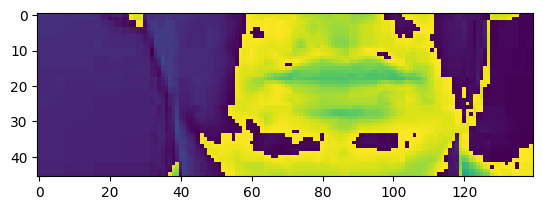

In [35]:
plt.imshow(frames[0])

In [39]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [38]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [42]:
def mappable_function(path: str) -> List[str]:
    # Tensorflow that involves raw string processing usually needs to be wrapped inside py_function()
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    
    return result

# Data Pipeline